# SLIX &ndash; Tutorial

This tutorial (Jupyter notebook) shows how the Scattered Light Imaging Toolbox (SLIX) can be used to analyze and evaluate SLI measurements. As an example, we use the SLI image stack of two crossing sections of optic tracts that is available on the EBRAINS data repository. First, we compute the different nerve fiber directions and average peak prominence. Second, we demonstrate how those can be visualized.

### General Imports

To start with, you need to import the required packages. Before execution, make sure that you have the rights to read and write in the folder of the notebook.

In [1]:
import sys
sys.path.append('../')

from SLIX import toolbox, visualization
from matplotlib import pyplot as plt
import tifffile
import numpy

import urllib.request

### Download Example File

Next, you need to download the SLI image stack you want to study from the EBRAINS data repository into the current directory of the notebook. We have chosen to download the image stack of two crossing optic tracts from a human optic chiasm.

In [2]:
# Download example image for visualization
input_file_name = './SLI-human-Sub-01_2xOpticTracts_s0037_30um_SLI_105_Stack_3days_registered.nii'
url = 'https://object.cscs.ch/v1/AUTH_227176556f3c4bb38df9feea4b91200c/hbp-d000048_ScatteredLightImaging_pub/Human_Brain/optic_tracts_crossing_sections/SLI-human-Sub-01_2xOpticTracts_s0037_30um_SLI_105_Stack_3days_registered.nii'
urllib.request.urlretrieve(url, input_file_name)

('./SLI-human-Sub-01_2xOpticTracts_s0037_30um_SLI_105_Stack_3days_registered.nii',
 <http.client.HTTPMessage at 0x7f1c68c02790>)

### Settings

The following lines set the parameters for the computation and visualization of the parameter maps. The `roisize` variable determines in which resolution the paramter maps are computed. We set the parameter to $1$ (full resolution). If the computation of the parameter maps (direction images, prominences) takes too long, you can set the paramter to a higher value and compute the parameter maps with lower resolution. The other varialbes set the size and resolution of the figures. If the figures do not appear correctly, you can change these values.

In [3]:
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['figure.dpi'] = 100

roisize = 1
output_folder = './output'

# Generate parameter maps though SLIXParameterGenerator

As shown in the [README.md](https://github.com/3d-pli/SLIX/blob/master/README.md) two programs are available to generate parameter maps from a complete SLI measurement. Here we want to generate the direction and peak prominence images to visualize them later. We use the dataset we downloaded earlier and save the resulting images in the output folder which we defined above.

In [4]:
%run ../bin/SLIXParameterGenerator -i {input_file_name} -o {output_folder} --direction --peakprominence --roisize {roisize}

SLI Feature Generator:
Number of threads: 16

Chosen feature maps:
Direction maps: True
Peak maps: False
Peak prominence map: True
Peak width map: False
Peak distance map: False
Optional maps: False

Prominence: 0.08
Peak height: 0.94

./SLI-human-Sub-01_2xOpticTracts_s0037_30um_SLI_105_Stack_3days_registered.nii


  0%|          | 0/1545264 [00:00<?, ?it/s]

Roi finished
Generating parameter maps.


100%|██████████| 1545264/1545264 [02:02<00:00, 12578.32it/s]


Parameter maps generated. Writing images.
Peak prominence written
Crossing directions written


After the parameter maps are generated and written to the disk, we can read them again using `tifffile`. We are stacking all three direction images to simplify the generation of unit vectors later on.

In [5]:
parameter_map_base_name = os.path.splitext(os.path.basename(path))[0]
# Read prominence
prominence_image = tifffile.imread(output_folder + '/' + parameter_map_base_name + '_peakprominence.tiff')
# Read all three directions into one image
direction_image = numpy.empty((prominence_image.shape[0], prominence_image.shape[1], 3))
for i in range(3):
    direction_image[:, :, i] = tifffile.imread(output_folder + '/' + parameter_map_base_name + '_dir_'+str(i+1)+'.tiff')

# Generate parameter maps through API

## Initialization

Subsequently, the SLI image stack is loaded and prepared for the evaluation with SLIX:

In [6]:
image = toolbox.read_image(input_file_name)
roiset = toolbox.create_roiset(image, roisize)

## Fiber Direction Angles

In the first example, we compute up to three (crossing) nerve fiber directions from the SLI image stack by analyzing the positions of prominent peak pairs in the SLI profiles. The in-plane direction angles are only computed if the SLI profile has one, two, four, or six prominent peaks with a pair-wise distance of $(180 \pm 35)^\circ$. Otherwise, the image pixel is set to $-1$. The direction angle is computed from the mid position of one peak pair, or (in case of only one peak) from the position of the peak itself. All direction angles are in degrees (with $0^\circ$ being along the positive x axis, and $90^\circ$ along the positive y-axis).

### Computation of Direction Images

The following lines compute the (crossing) fiber direction angles from the SLI image stack, yielding an array with three different direction images.


In [7]:
direction = toolbox.crossing_direction_image(roiset)
direction_image = toolbox.reshape_array_to_image(direction, image.shape[0], roisize)

Direction: 100%|██████████| 1545264/1545264 [01:44<00:00, 14779.82it/s]


### Computation of Prominence Image

The following lines compute the average prominence per pixel from the SLI image stack, yielding a one dimensional array.

In [8]:
prominence = toolbox.prominence_image(roiset)
prominence_image = toolbox.reshape_array_to_image(prominence, image.shape[0], roisize)

Peak prominence: 100%|█████████▉| 1544685/1545264 [00:18<00:00, 82144.07it/s]


## Visualize results

Using the `visualization` module of SLIX, the direction images can be easily visualized:

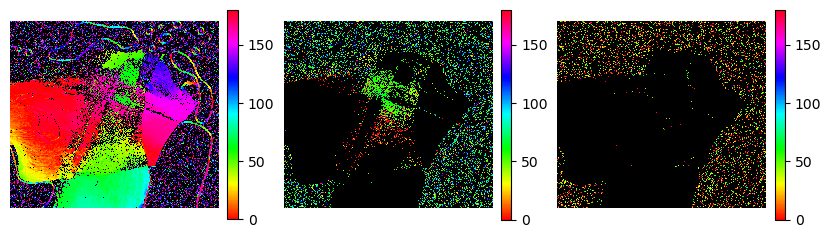

In [9]:
fig, axs = plt.subplots(1, 3)
for i in range(direction_image.shape[-1]):
    visualization.visualize_parameter_map(direction_image[:, :, i], cmap='hsv', fig=fig, ax=axs[i],
                                          vmin=0, vmax=180, colorbar=True)
plt.show()

The left image shows the first detected in-plane nerve fiber direction in different colors, i.e. the direction angles of regions with parallel fibers and the first direction angle of regions with several crossing fibers. The other two images show the second and third detected fiber direction in regions with two or three crossing fibers, respectively. As our sample consists only of two crossing fiber bundles, there exist regions where a second fiber orientation is visible (in the middle) but no regions with a third fiber orientation (on the right).

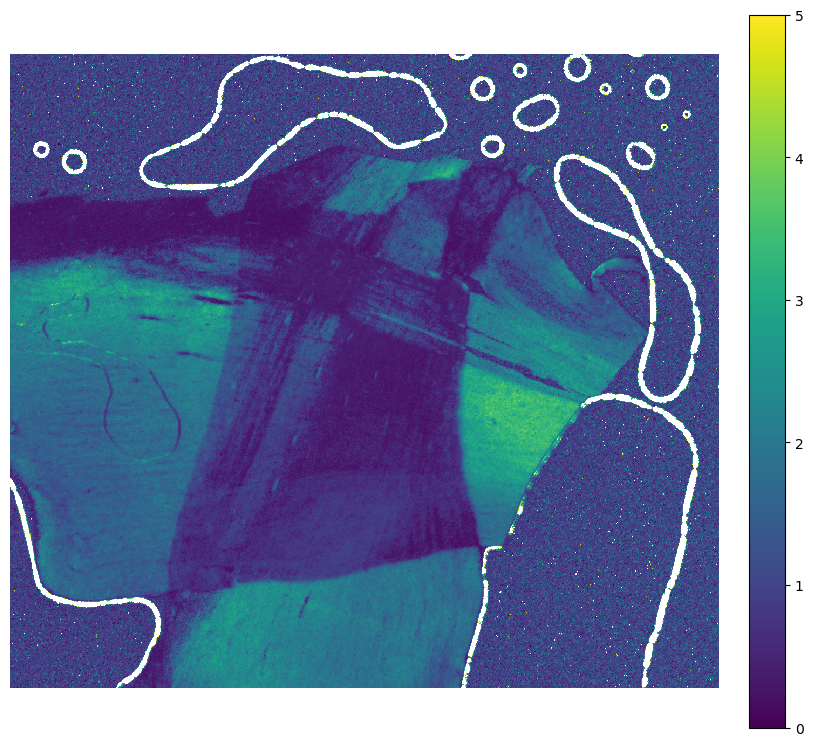

In [10]:
visualization.visualize_parameter_map(prominence_image[:, :], vmax=5)
plt.axis('off')
plt.show()

As expected, the peaks in the SLI profiles have lower prominences in regions with crossing fibers than in regions with parallel fibers, which implies that the signal-to-noise ratio is lower in crossing regions.

## Computation of Unit Vector Maps

For further analysis and to visualize the orientations (vectors) of the fibers, the direction images need to be converted to unit vector maps. For this purpose, SLIX provides the following method:

In [11]:
UnitX, UnitY = visualization.unit_vectors(direction_image)

For each direction angle between 0° and 180°, the x- and y-component of the corresponding unit vector are computed. This allows to represent the fiber directions as vectors (lines) and project them onto the original image (e.g. the average of the SLI image stack). For this purpose, we use the `thinout` parameter. Choosing a value of $1$ means that each image pixel contains a fiber direction vector. To make the vector lines visible on the original image, a higher value should be chosen. The parameter `alpha` determines the transparency of the original image that is shown in the background of the vector map.

The following example shows what happens when no thinout is used.

In [12]:
thinout = 1
alpha = 0.8

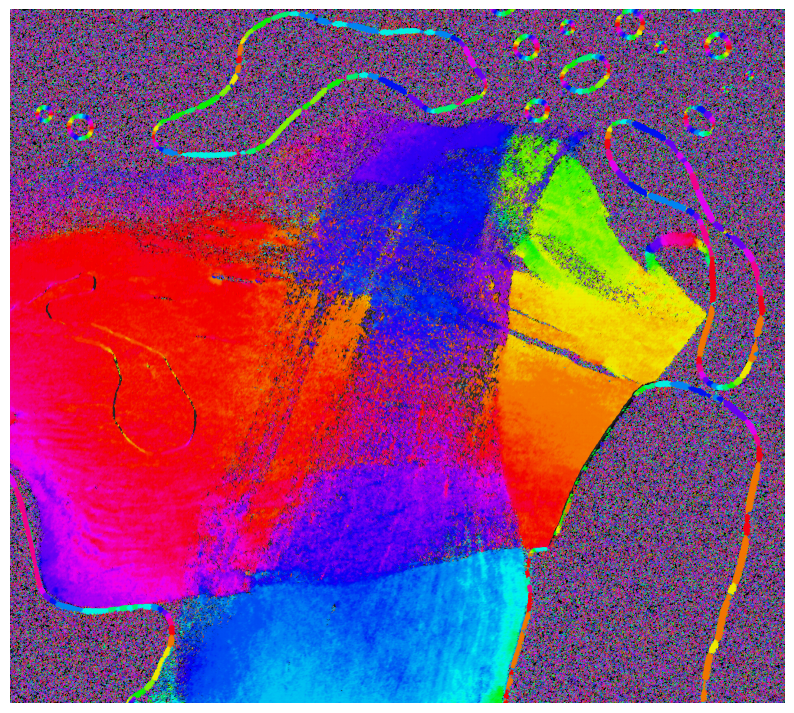

In [13]:
image = toolbox.read_image(input_file_name)

plt.imshow(numpy.average(image[::roisize, ::roisize], axis=-1), cmap='gray')
visualization.visualize_unit_vectors(UnitX, UnitY, thinout=thinout, alpha=alpha)
plt.axis('off')
plt.show()

When zooming into a small region of the image, we obtain:

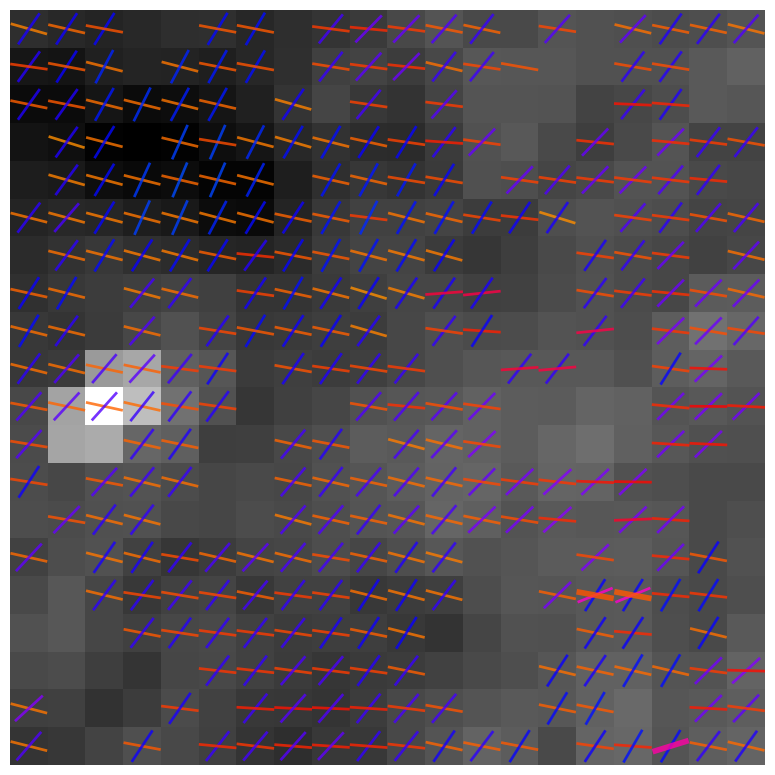

In [14]:
image_roi = image[560//roisize:580//roisize, 610//roisize:630//roisize]
UnitX_roi = UnitX[560//roisize:580//roisize, 610//roisize:630//roisize]
UnitY_roi = UnitY[560//roisize:580//roisize, 610//roisize:630//roisize]


plt.imshow(numpy.average(image_roi, axis=-1), cmap='gray')
visualization.visualize_unit_vectors(UnitX_roi, UnitY_roi)
plt.axis('off')
plt.show()

Each image pixel shows up to three different nerve fiber directions. In this example (two crossing fiber bundles), mostly two different orientations are visible. In regions where the scattering signals are too weak or not reliable, no fiber direction is computed.

To visualize the vector map for the whole tissue sample, we use a higher value for the `thinout` parameter. When using a value of 2, for example, the median direction of 2 x 2 image pixels is computed for each direction image. Image pixels with values of $-1$ (where no fiber direction can be computed) are ignored unless they represent more than 50% of the surrounding pixels. 

In [15]:
thinout = 20
alpha = 0.8
background_threshold = 0.9

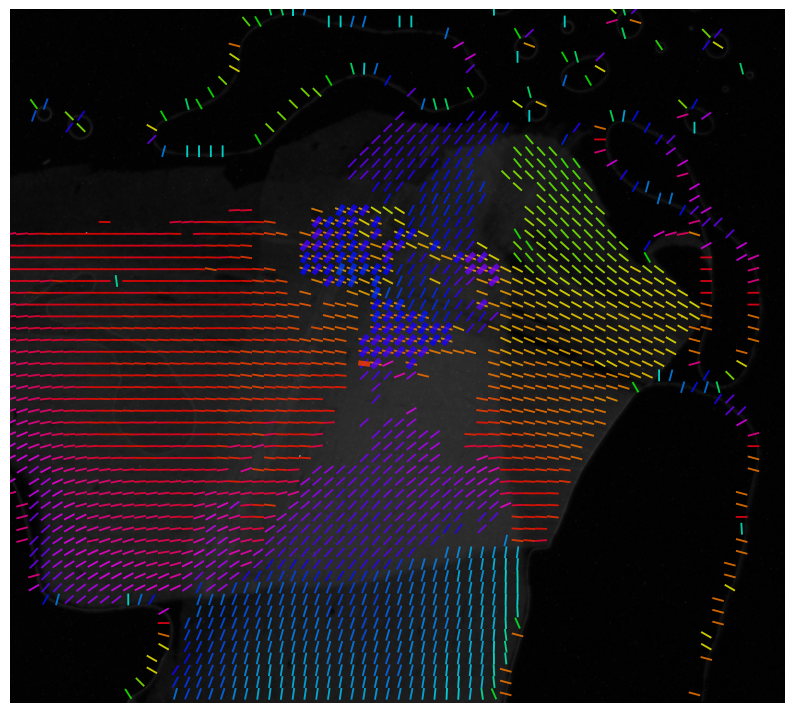

In [16]:
plt.imshow(numpy.average(image[::roisize, ::roisize], axis=-1), cmap='gray') 
visualization.visualize_unit_vectors(UnitX, UnitY, thinout=thinout, alpha=alpha)
plt.axis('off')
plt.show()